In [1]:
from google.colab import drive
import os
import gdown # Library to download files from Google Drive
!gdown 1JdGaXmUnItfCn8ucn_5kBfDeh3NzrmMs # Google Drive ID of the zip file to be downloaded


Downloading...
From (original): https://drive.google.com/uc?id=1JdGaXmUnItfCn8ucn_5kBfDeh3NzrmMs
From (redirected): https://drive.google.com/uc?id=1JdGaXmUnItfCn8ucn_5kBfDeh3NzrmMs&confirm=t&uuid=27a83555-759f-4559-9016-b30b7a041c92
To: /content/images.zip adlı dosyanın kopyası
100% 128M/128M [00:01<00:00, 87.9MB/s]


In [2]:
!unzip -oq images # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

In [3]:

root_dir = '/content/images'


In [4]:
import gdown

# Define the Google Drive file ID for the responses.json file
file_id = '1nktUlbNE4lZHrJ83d0B3msZy_R12Sa3o'

# Define the output path for the downloaded file
output_path = '/content/ad_responses.json'

# Download the file using gdown
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1nktUlbNE4lZHrJ83d0B3msZy_R12Sa3o
To: /content/ad_responses.json
100%|██████████| 11.5M/11.5M [00:00<00:00, 103MB/s] 


'/content/ad_responses.json'

In [5]:
import json
import os
from PIL import Image
import numpy as np


# Load the JSON data
responses_file = '/content/ad_responses.json'
with open(responses_file, 'r') as f:
    data = json.load(f)

# Create a dictionary to map '_id' to ad_info for faster lookup
ad_info_dict = {info['_id']: info for info in data.values() if '_id' in info}
# Define the root directory for images
images_dir = '/content/images'

# Define the target dimensions for resizing images (lower resolution for efficiency)
target_width = 512   # Lower resolution
target_height = 512  # Lower resolution

# Initialize lists to store calculated and extracted features
campaign_data = []


# Iterate through each image in the images directory
for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):  # Check if the file is a JPEG image
        image_id = filename.split('.')[0]  # Extract ID from filename
        for key, value in ad_info_dict.items():
          if '_id' in value and value['_id'] == image_id:
            ad_info = value
            image_path = os.path.join(images_dir, filename)

            # Load and preprocess the image
            with Image.open(image_path) as img:
                img = img.convert('RGB')  # Convert image to RGB format
                img = img.resize((target_width, target_height))  # Resize image to lower resolution
                img_array = np.array(img)  # Convert image to numpy array

            # Process only the necessary data to reduce memory load
            avg_spend = np.mean([int(ad_info.get("spend", {}).get("lower_bound", 0)), int(ad_info.get("spend", {}).get("upper_bound", 0))])
            avg_impressions = np.mean([int(ad_info.get("impressions", {}).get("lower_bound", 0)), int(ad_info.get("impressions", {}).get("upper_bound", 0))])
            cost_per_impression = avg_spend / avg_impressions if avg_impressions > 0 else float('inf')

            # Append only necessary info to reduce memory footprint
            campaign_data.append({
                "ad_id": ad_info.get('_id', ''),
                "cost" : avg_spend,
                "impression": avg_impressions,
                "cpi": cost_per_impression,
                "image_data": img_array.flatten().tolist()  # Flatten and convert to list to minimize size
            })
            break

# Example: Print or save to file
# for campaign in campaign_data[:3]:
#     print(json.dumps(campaign, indent=2))

# Instead of printing, consider saving processed data to disk to free memory
import pickle
with open('/content/campaign_data.pkl', 'wb') as f:
    pickle.dump(campaign_data, f)

# Clear the large variables from memory
del campaign_data
del data


In [6]:
count = 0
for key, value in ad_info_dict.items():
    print(key, value)
    count += 1
    if count == 10:
        break
#example
desired_id = '716911622011048'
found_element = None

for key, value in ad_info_dict.items():
    if '_id' in value and value['_id'] == desired_id:
        found_element = value
        break

if found_element:
    print("Element found:")
    print(found_element)
else:
    print("Element with _id =", desired_id, "not found.")

2080535325365336 {'_id': '2080535325365336', 'ad_creation_time': '2019-03-20', 'ad_creative_bodies': ['Donald Trump HATES anybody that tells the truth about him — that’s why he jumps at every chance to ATTACK reputable news outlets like MSNBC. Americans rely on the free press for fair and accurate news, but Trump would rather feed Americans lies through his propaganda machine (FOX News!!) If voters fall for his deception, we may NEVER end his presidency. So we need to know what news sources top Democrats like you rely on. \n\nTake our 1-click poll now >>'], 'ad_creative_link_captions': ['go.boldpac.com'], 'ad_creative_link_descriptions': ['Take Our 1-Click Poll Before Midnight\n'], 'ad_creative_link_titles': ['🎉1 in 500: You’ve Been Selected!'], 'ad_delivery_start_time': '2019-03-20', 'ad_delivery_stop_time': '2019-03-30', 'bylines': 'CHC BOLD PAC', 'currency': 'USD', 'delivery_by_region': [{'percentage': '0.012235', 'region': 'Alabama'}, {'percentage': '0.011835', 'region': 'South Car

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, image_filenames,labels, batch_size, image_directory, dim=(512, 512), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.image_filenames = image_filenames
        self.image_directory = image_directory
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        image_filenames_temp = [self.image_filenames[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_filenames_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_filenames_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=float)

        # Generate data
        for i, image_filename in enumerate(image_filenames_temp):
            # Store sample
            img = load_img(os.path.join(self.image_directory, image_filename + '.jpg'), target_size=self.dim)
            X[i,] = img_to_array(img) / 255.0

            # Store class
            y[i] = self.labels[image_filename]

        return X, y


In [7]:
import pickle

# Load the processed data from disk
with open('/content/campaign_data.pkl', 'rb') as f:
    campaign_data = pickle.load(f)
# Initialize variables to hold max and min CPI values
max_cpi = float('-inf')
min_cpi = float('inf')


# Perform Min-Max scaling on CPI values
min_cpi = min(campaign["cpi"] for campaign in campaign_data)
max_cpi = max(campaign["cpi"] for campaign in campaign_data)

for campaign in campaign_data:
    campaign["normalized_cpi"] = (campaign["cpi"] - min_cpi) / (max_cpi - min_cpi)

# Print the maximum and minimum CPI values
print("Maximum CPI value:", max_cpi)
print("Minimum CPI value:", min_cpi)
# Print the first few entries of the campaign data to verify
for campaign in campaign_data[:3]:  # Adjust the range as needed for more samples
    print("Ad ID:", campaign["ad_id"])
    print("Cost Per Impression (CPI):", campaign["normalized_cpi"])
    print("Sample Image Data (flattened):", campaign["image_data"][:10])  # Show only the first 10 pixels to keep output manageable
    print("\n")


Maximum CPI value: 0.549999
Minimum CPI value: 0.0022000488899753326
Ad ID: 548719072217776
Cost Per Impression (CPI): 0.13289355695645189
Sample Image Data (flattened): [29, 32, 23, 31, 34, 23, 35, 37, 26, 38]


Ad ID: 627193601016101
Cost Per Impression (CPI): 0.03066627103973885
Sample Image Data (flattened): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Ad ID: 306793176583713
Cost Per Impression (CPI): 0.017865637714736857
Sample Image Data (flattened): [70, 108, 144, 69, 107, 143, 67, 105, 141, 67]




In [8]:
import tensorflow as tf

# Check TensorFlow GPU usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU")
else:
    print("TensorFlow will run on CPU")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Num GPUs Available:  1
TensorFlow will run on GPU
1 Physical GPUs, 1 Logical GPUs


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from sklearn.model_selection import train_test_split

def create_model(optimizer='adam', activation='relu', filters=32, kernel_size=(3,3), pool_size=(2,2), hidden_units=128):
    inputs = Input(shape=(512, 512, 3))
    model = Sequential([
        Conv2D(filters, kernel_size, activation=activation, input_shape=(512, 512, 3)),
        MaxPooling2D(pool_size),
        Conv2D(filters*2, kernel_size, activation=activation),
        MaxPooling2D(pool_size),
        Flatten(),
        Dense(hidden_units, activation=activation),
        Dense(1)
    ])
    return model



# Assuming you have a dictionary mapping from image IDs to CPI and file names
image_filenames = [campaign['ad_id'] for campaign in campaign_data]  # ID is used as filename
labels = {campaign['ad_id']: campaign['normalized_cpi'] for campaign in campaign_data}
image_directory = '/content/images'

# Splitting the dataset
image_filenames_train, image_filenames_test, labels_train, labels_test = train_test_split(
    image_filenames, [labels[id] for id in image_filenames], test_size=0.2, random_state=42)

# Create the generator
batch_size = 10  # Depends on your available memory
train_generator = DataGenerator(image_filenames=image_filenames_train, labels=dict(zip(image_filenames_train, labels_train)), batch_size=batch_size, image_directory=image_directory)
test_generator = DataGenerator(image_filenames=image_filenames_test, labels=dict(zip(image_filenames_test, labels_test)), batch_size=batch_size, image_directory=image_directory)

# Define your model's input shape based on the data dimensions you will train on
input_shape = (512, 512, 3)  # Modify according to your resized image dimensions


50


Epoch 1/10
50/50 [==============================] - 19s 251ms/step - loss: 688.1365 - mean_absolute_error: 5.7461 - val_loss: 0.0851 - val_mean_absolute_error: 0.2652
Epoch 2/10
50/50 [==============================] - 13s 263ms/step - loss: 0.0216 - mean_absolute_error: 0.1050 - val_loss: 0.0100 - val_mean_absolute_error: 0.0595
Epoch 3/10
50/50 [==============================] - 13s 252ms/step - loss: 0.0085 - mean_absolute_error: 0.0591 - val_loss: 0.0080 - val_mean_absolute_error: 0.0570
Epoch 4/10
50/50 [==============================] - 13s 257ms/step - loss: 0.0074 - mean_absolute_error: 0.0539 - val_loss: 0.0071 - val_mean_absolute_error: 0.0550
Epoch 5/10
50/50 [==============================] - 13s 264ms/step - loss: 0.0065 - mean_absolute_error: 0.0490 - val_loss: 0.0067 - val_mean_absolute_error: 0.0521
Epoch 6/10
50/50 [==============================] - 13s 250ms/step - loss: 0.0058 - mean_absolute_error: 0.0440 - val_loss: 0.0067 - val_mean_absolute_error: 0.0505
Epoch 7/

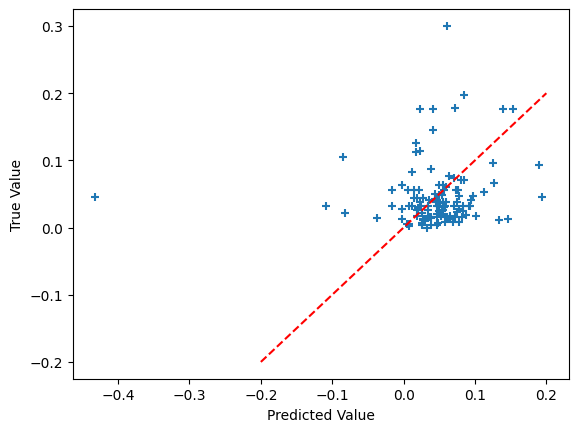

Epoch 1/10
50/50 [==============================] - 15s 264ms/step - loss: 87.2053 - mean_absolute_error: 9.0975 - val_loss: 40.9791 - val_mean_absolute_error: 6.4013
Epoch 2/10
50/50 [==============================] - 13s 252ms/step - loss: 19.4951 - mean_absolute_error: 4.2643 - val_loss: 6.1028 - val_mean_absolute_error: 2.4699
Epoch 3/10
50/50 [==============================] - 13s 248ms/step - loss: 2.3438 - mean_absolute_error: 1.4386 - val_loss: 0.4694 - val_mean_absolute_error: 0.6836
Epoch 4/10
50/50 [==============================] - 13s 254ms/step - loss: 0.1463 - mean_absolute_error: 0.3434 - val_loss: 0.0197 - val_mean_absolute_error: 0.1353
Epoch 5/10
50/50 [==============================] - 13s 258ms/step - loss: 0.0086 - mean_absolute_error: 0.0741 - val_loss: 0.0028 - val_mean_absolute_error: 0.0442
Epoch 6/10
50/50 [==============================] - 13s 250ms/step - loss: 0.0050 - mean_absolute_error: 0.0427 - val_loss: 0.0023 - val_mean_absolute_error: 0.0358
Epoch 7

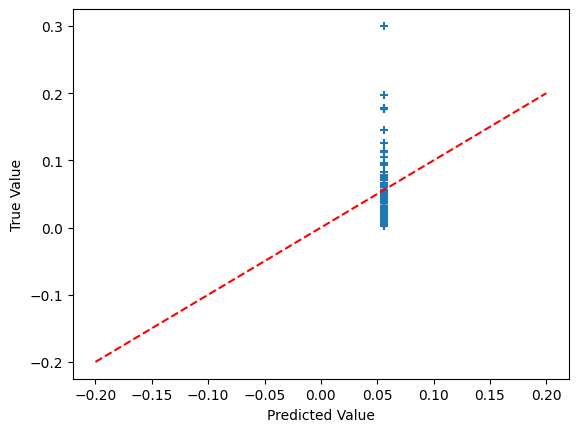

Epoch 1/10
50/50 [==============================] - 14s 245ms/step - loss: 799.8000 - mean_absolute_error: 5.5360 - val_loss: 0.0147 - val_mean_absolute_error: 0.0884
Epoch 2/10
50/50 [==============================] - 12s 245ms/step - loss: 0.0255 - mean_absolute_error: 0.1013 - val_loss: 0.0105 - val_mean_absolute_error: 0.0741
Epoch 3/10
50/50 [==============================] - 13s 261ms/step - loss: 0.0158 - mean_absolute_error: 0.0755 - val_loss: 0.0068 - val_mean_absolute_error: 0.0564
Epoch 4/10
50/50 [==============================] - 12s 243ms/step - loss: 0.0097 - mean_absolute_error: 0.0549 - val_loss: 0.0046 - val_mean_absolute_error: 0.0461
Epoch 5/10
50/50 [==============================] - 13s 250ms/step - loss: 0.0074 - mean_absolute_error: 0.0448 - val_loss: 0.0056 - val_mean_absolute_error: 0.0540
Epoch 6/10
50/50 [==============================] - 13s 249ms/step - loss: 0.0068 - mean_absolute_error: 0.0425 - val_loss: 0.0047 - val_mean_absolute_error: 0.0450
Epoch 7/

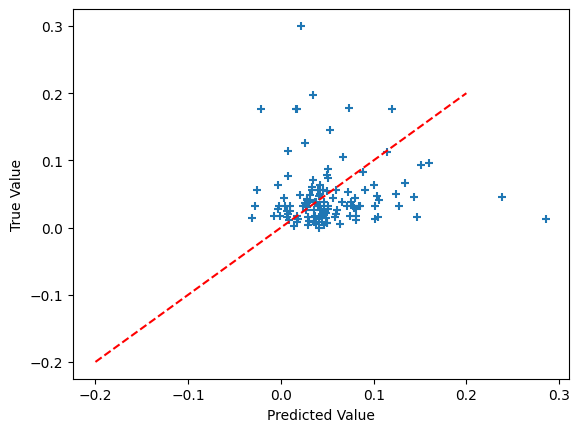

Epoch 1/10
50/50 [==============================] - 16s 254ms/step - loss: 100.4786 - mean_absolute_error: 9.7903 - val_loss: 50.0570 - val_mean_absolute_error: 7.0750
Epoch 2/10
50/50 [==============================] - 13s 261ms/step - loss: 25.1245 - mean_absolute_error: 4.8672 - val_loss: 8.8698 - val_mean_absolute_error: 2.9779
Epoch 3/10
50/50 [==============================] - 13s 255ms/step - loss: 3.6876 - mean_absolute_error: 1.8260 - val_loss: 0.8944 - val_mean_absolute_error: 0.9446
Epoch 4/10
50/50 [==============================] - 13s 254ms/step - loss: 0.3075 - mean_absolute_error: 0.5116 - val_loss: 0.0505 - val_mean_absolute_error: 0.2203
Epoch 5/10
50/50 [==============================] - 13s 261ms/step - loss: 0.0172 - mean_absolute_error: 0.1128 - val_loss: 0.0034 - val_mean_absolute_error: 0.0544
Epoch 6/10
50/50 [==============================] - 13s 252ms/step - loss: 0.0051 - mean_absolute_error: 0.0473 - val_loss: 0.0023 - val_mean_absolute_error: 0.0358
Epoch 

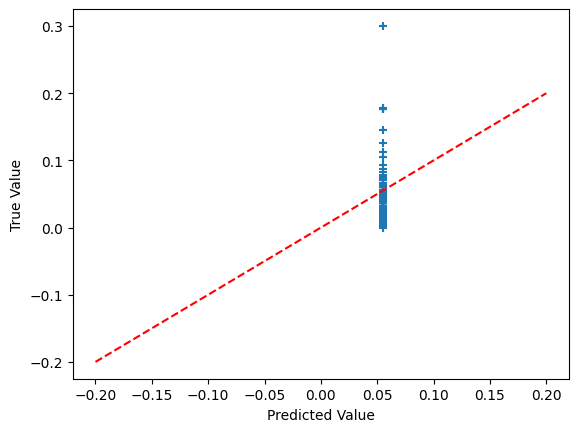

In [ ]:
i = 0
optimizer=['adam', 'sgd']
activation=['relu', 'tanh']
filters=32
kernel_size=(3,3)
pool_size=(2,2)
hidden_units=128
for i in range(0,2):
  for j in range(0,2):

    # Create the model
    model = create_model(optimizer[i],activation[j], filters,kernel_size,pool_size,hidden_units)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    # Now use this generator directly in model.fit
    model.fit(train_generator, epochs=10, validation_data=test_generator)
    print("With", optimizer[i], activation[j])
    test_loss, test_mae = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss}")
    print(f"Mean Absolute Error (MAE): {test_mae}")
    test_cpis = []
    for batch_images, batch_labels in test_generator:
      test_cpis.extend(batch_labels)  # Assuming batch_images contains the image filenames, which are the IDs
    import matplotlib.pyplot as plt

    test_predict = model.predict(test_generator)
    count = 0
    # Create the scatter plot
    plt.figure()
    plt.scatter(test_predict, test_cpis, marker="+")
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")

    # Add a reference line
    plt.plot([-0.2, 0.2], [-0.2, 0.2], "r--")  # Assuming the range of values is -60 to 60, adjust as needed

    # Show the plot
    plt.show()

In [ ]:
#abs - squared error
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Mean Absolute Error (MAE): {test_mae}")

12/12 [==============================] - 2s 165ms/step - loss: 0.0089 - mean_absolute_error: 0.0684
Test Loss: 0.008921557106077671
Mean Absolute Error (MAE): 0.06838735938072205


In [ ]:
#squared error - abs error
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Mean Absolute Error (MAE): {test_mae}")



12/12 [==============================] - 2s 164ms/step - loss: 0.0280 - mean_squared_error: 0.0024
Test Loss: 0.028036927804350853
Mean Absolute Error (MAE): 0.0024414174258708954


In [ ]:
test_cpis = []
for batch_images, batch_labels in test_generator:
    test_cpis.extend(batch_labels)  # Assuming batch_images contains the image filenames, which are the IDs

# Now test_ids contains all the IDs in the test generator
print("CPIs in the test generator:", test_cpis)


CPIs in the test generator: [0.04702650398026845, 0.02201081491907308, 0.02960180459741304, 0.032485632729035256, 0.08236275540153719, 0.03244246867211022, 0.07064694602493639, 0.016259007290586793, 0.03246105632039105, 0.007793681381026724, 0.11212013005683279, 0.023900940758797166, 0.07880210746674683, 0.0032615450053988682, 0.056245005061584405, 0.024372320009811026, 0.03246105632039105, 0.17820391022109935, 0.024179575450334334, 0.017817539645491334, 0.02760169952096218, 0.07104799473855919, 0.05663732111498065, 0.015637375839347243, 0.004381209338719909, 0.07623546831504557, 0.017817539645491334, 0.049526739576691625, 0.044004266746942924, 0.0, 0.006615242864470131, 0.03248707837910396, 0.3001302908376023, 0.03242202181287989, 0.01622691391820025, 0.0661678821602712, 0.01606642993790024, 0.0152912781446841, 0.06322012426662979, 0.0324747522351308, 0.043929422099516384, 0.032485632729035256, 0.03797327547770541, 0.1768879805497505, 0.06373742993122161, 0.026396659117602986, 0.12632

12/12 [==============================] - 2s 193ms/step
[0.02647902]
0.011803521847312143
[0.04186739]
0.03242202181287989
[0.01740394]
0.0789288493333154
[0.01904759]
0.0324538278364005
[-0.02725334]
0.01788487622416865
[0.02066272]
0.1768879805497505
[0.19861428]
0.10165183930600354
[0.03655349]
0.03244246867211022
[0.05232014]
0.03244246867211022
[0.06896523]
0.059262697531314086
[-0.07398589]
0.031087985597335135
[0.03008849]
0.01622691391820025


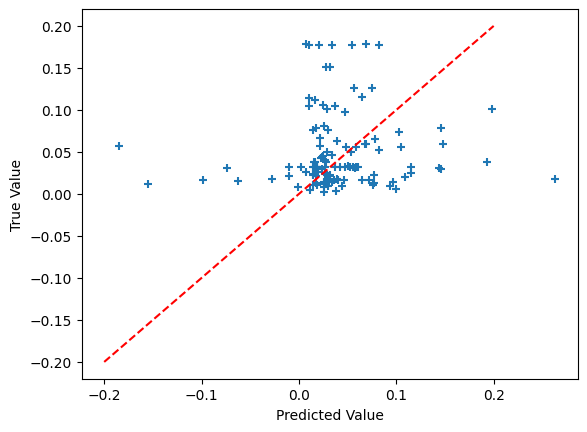

In [ ]:
#abs error - squared error

import matplotlib.pyplot as plt

test_predict = model.predict(test_generator)
count = 0
for i in range (0,12):
  print(test_predict[i])
  print(test_cpis[i])
# Create the scatter plot
plt.figure()
plt.scatter(test_predict, test_cpis, marker="+")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

# Add a reference line
plt.plot([-0.2, 0.2], [-0.2, 0.2], "r--")  # Assuming the range of values is -60 to 60, adjust as needed

# Show the plot
plt.show()

12/12 [==============================] - 2s 164ms/step
[0.03041034]
0.04702650398026845
[0.02308865]
0.02201081491907308
[0.02797331]
0.02960180459741304
[0.03041034]
0.032485632729035256
[0.02209216]
0.08236275540153719
[0.03041034]
0.03244246867211022
[0.02999464]
0.07064694602493639
[0.02477111]
0.016259007290586793
[0.02766957]
0.03246105632039105
[0.03016441]
0.007793681381026724
[0.01523442]
0.11212013005683279
[0.04835834]
0.023900940758797166


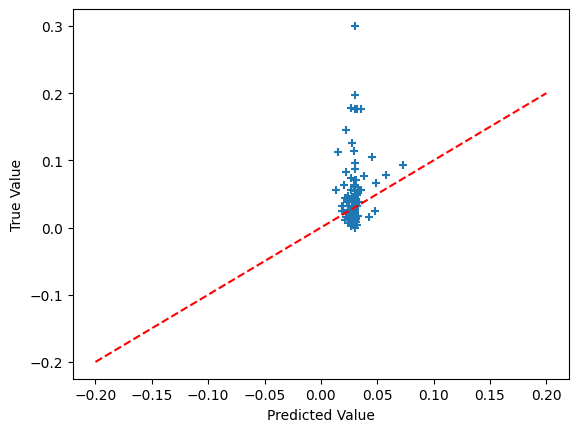

In [ ]:
#squared error - abs error
import matplotlib.pyplot as plt

test_predict = model.predict(test_generator)
count = 0
for i in range (0,12):
  print(test_predict[i])
  print(test_cpis[i])
# Create the scatter plot
plt.figure()
plt.scatter(test_predict, test_cpis, marker="+")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

# Add a reference line
plt.plot([-0.2, 0.2], [-0.2, 0.2], "r--")  # Assuming the range of values is -60 to 60, adjust as needed

# Show the plot
plt.show()

In [ ]:
import random
import numpy as np
import math

image_path = os.path.join(images_dir, '2017251175005413.jpg')
img = Image.open(image_path)
img = img.convert('RGB')  # Convert image to RGB format
img = img.resize((512, 512))  # Resize image to match input shape expected by the model

# Convert the image to a numpy array
img_array = np.array(img)  # Convert image to numpy array
img_array = img_array / 255.0  # Normalize pixel values to range [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Use the model to make predictions
predicted_cpi = model.predict(img_array)
# Assuming campaign_data is a dictionary where each key is an ad ID

# Search for the element with _id = '716911622011048'
desired_id = '2017251175005413'
found_element = None
print("Predicted CPI value:", predicted_cpi)
for campaign in campaign_data:
    if campaign["ad_id"] == desired_id:
        desired_cpi = campaign["normalized_cpi"]
        print("Actual CPI value:",desired_cpi)
        print("Error Rate:", (desired_cpi - predicted_cpi) / desired_cpi )
        break

# Print the predicted CPI value



1/1 [==============================] - 0s 19ms/step
Predicted CPI value: [[0.05382203]]
Actual CPI value: 0.1261335940571177
Error Rate: [[0.5732935]]


In [ ]:
import joblib
# Save the model
model.save('content/modelCPIComparison.keras')

# Load the model
#from tensorflow.keras.models import load_model
#prod_model = load_model('modelCPIComparison.h5')

joblib.dump(model, '/content/drive/MyDrive/CS491MLMODEL/us/us/gb_regressor_suggestion.joblib')



# Mixed Input Model Using


In [ ]:

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

# Define the input layers for ad images and cost
image_input = Input(shape=(512, 512, 3))
cost_input = Input(shape=(1,))

# CNN pathway for processing ad images
conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(pool2)

# Concatenate the flattened image features with the cost input
concatenated_features = concatenate([flatten, cost_input])

# Fully connected layers for prediction
dense1 = Dense(128, activation='relu')(concatenated_features)
output = Dense(1, activation='linear')(dense1)
model = Model(inputs=[image_input, cost_input], outputs=output)





In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, image_filenames, labels, costs, batch_size, image_directory, dim=(512, 512), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.costs = costs
        self.image_filenames = image_filenames
        self.image_directory = image_directory
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        image_filenames_temp = [self.image_filenames[k] for k in indexes]
        X, y = self.__data_generation(image_filenames_temp)
        cost_input = np.array([self.costs[idx] for idx in indexes]).reshape(-1, 1)
        return [X, cost_input], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_filenames_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=float)

        # Generate data
        for i, image_filename in enumerate(image_filenames_temp):
            # Store sample
            img = load_img(os.path.join(self.image_directory, image_filename + '.jpg'), target_size=self.dim)
            X[i,] = img_to_array(img) / 255.0
            # Store class and cost
            y[i] = self.labels[image_filename]

        return X,y  # Return both labels and costs


In [9]:
from sklearn.model_selection import train_test_split
# Assuming you have your image data, cost data, and impression labels loaded and preprocessed
# X_images: array of image data (num_samples, height, width, channels)
# X_cost: array of cost data (num_samples, 1)
# y_impressions: array of impression labels (num_samples,)

def min_max_scaling(data, min_range=0, max_range=1):
    min_val = min(data)
    max_val = max(data)
    scaled_data = [(x - min_val) / (max_val - min_val) * (max_range - min_range) + min_range for x in data]
    print(max_val,min_val)
    return scaled_data

# Split the dataset into train and test sets
# Assuming you have a dictionary mapping from image IDs to CPI and file names
image_filenames = [campaign['ad_id'] for campaign in campaign_data]  # ID is used as filename
ad_costs = [campaign['cost'] for campaign in campaign_data]
ad_costs = min_max_scaling(ad_costs)
scaled_impression = min_max_scaling(campaign['impression'])
labels = {campaign['ad_id']: scaled_impression for campaign in campaign_data}

images =[]
image_directory = '/content/images'


# Splitting the dataset
image_filenames_train, image_filenames_test, costs_train, costs_test, labels_train, labels_test = train_test_split(
    image_filenames,ad_costs,[labels[file] for file in image_filenames], test_size=0.2, random_state=42)

#labels_dict_train = dict(zip(image_filenames_train, labels_train))
#costs_dict_train = dict(zip(image_filenames_train, costs_train))

'''
# Create the generator
batch_size = 10  # Depends on your available memory

# Create the generator
labels_dict_test = dict(zip(image_filenames_test, labels_test))
costs_dict_test = dict(zip(image_filenames_test, costs_test))

batch_size = 10  # Depends on your available memory
test_generator = DataGenerator(image_filenames=image_filenames_test,
                                costs=costs_dict_test,
                                labels=labels_dict_test,
                                batch_size=batch_size,
                                image_directory=image_directory)

'''


274999.5 49.5


TypeError: 'numpy.float64' object is not iterable

In [ ]:
print(len(train_generator))
print(len(test_generator))
print("Type of image_filenames_train:", type(image_filenames_train))
print("Type of costs_train:", type(labels_train))
print("Type of image_filenames_test:", type(image_filenames_test))
print("Type of costs_test:", type(costs_test))


63
16
Type of image_filenames_train: <class 'list'>
Type of costs_train: <class 'list'>
Type of image_filenames_test: <class 'list'>
Type of costs_test: <class 'list'>


In [ ]:
# Create the generator
train_generator = DataGenerator(image_filenames=image_filenames_train,
                                costs=costs_train,
                                labels=dict(zip(image_filenames_train, labels_train)),
                                batch_size=4,
                                image_directory=image_directory)
test_generator = DataGenerator(image_filenames=image_filenames_test,
                                costs=costs_test,
                                labels=dict(zip(image_filenames_test, labels_test)),
                                batch_size=4,
                                image_directory=image_directory)


model.compile(loss="mean_absolute_percentage_error", optimizer='adam')
# train the model
print("[INFO] training model...")
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=2, batch_size=4)




[INFO] training model...
Epoch 1/2
127/127 [==============================] - 19s 118ms/step - loss: 29.9126 - val_loss: 647.8244
Epoch 2/2
127/127 [==============================] - 15s 117ms/step - loss: 32.7736 - val_loss: 634.8419


In [ ]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict(test_generator)
diff = preds.flatten() - labels_test
percentDiff = (diff / labels_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("Test Loss:", mean)
print("Test MAE:", std)


[INFO] predicting house prices...
32/32 [==============================] - 3s 83ms/step
Test Loss: 664.7352129507797
Test MAE: 1745.2392708281368


In [ ]:
import random
import numpy as np
import math
desired_id = '334500590448001'
max_val = 274999.5
min_val = 49.5
image_path = os.path.join(images_dir, '334500590448001.jpg')
img = Image.open(image_path)
img = img.convert('RGB')  # Convert image to RGB format
img = img.resize((512, 512))  # Resize image to match input shape expected by the model
for campaign in campaign_data:
    if campaign["ad_id"] == desired_id:
        desired_prediction = campaign["impression"]
        cost = campaign["cost"]
        print(max_val, min_val)
        cost = (cost - min_val) / (max_val - min_val) * (1 - 0) + 0
        print("Actual Prediction value:",desired_prediction)
        break
# Convert the image to a numpy array
img_array = np.array(img)  # Convert image to numpy array
img_array = img_array / 255.0  # Normalize pixel values to range [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Use the model to make predictions
prediction = model.predict([img_array, cost.reshape(-1, 1)])
# Assuming campaign_data is a dictionary where each key is an ad ID

# Search for the element with _id = '716911622011048'
found_element = None
print("Predicted CPI value:", prediction)
print("Error Rate:", (desired_prediction - prediction) / desired_prediction )

# Print the predicted CPI value


274999.5 49.5
Actual Prediction value: 8499.5
1/1 [==============================] - 0s 21ms/step
Predicted CPI value: [[8851.724]]
Error Rate: [[-0.04144051]]


127/127 [==============================] - 10s 79ms/step
{'981862068667402': array([9623.158], dtype=float32), '728694627464614': array([52303.75], dtype=float32), '280355752784645': array([46166.25], dtype=float32), '316608352454246': array([22910.1], dtype=float32), '697338393981355': array([94102.336], dtype=float32), '2000642720227913': array([3976.351], dtype=float32), '277945566213495': array([17984.973], dtype=float32), '2161955667355059': array([139902.56], dtype=float32), '450059192068873': array([32729.322], dtype=float32), '693100977739664': array([2482.565], dtype=float32), '704505163256105': array([49307.992], dtype=float32), '332529730824689': array([23931.6], dtype=float32), '2077645139230873': array([33599.086], dtype=float32), '1016716388510560': array([8412.403], dtype=float32), '510270412780227': array([12288.958], dtype=float32), '510303972780945': array([61384.848], dtype=float32), '217830592228545': array([54680.875], dtype=float32), '318600295362595': array([1586

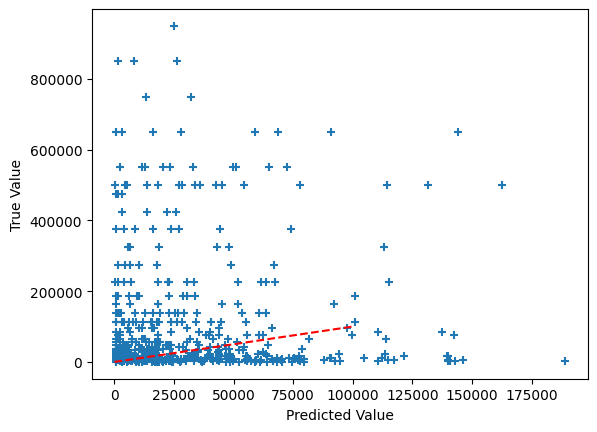

In [ ]:
import matplotlib.pyplot as plt
actual_prediction = []
train_image_ids = train_generator.image_filenames
train_predict = model.predict(train_generator)
# Combine image IDs with predictions
predictions_with_ids = dict(zip(train_image_ids, train_predict))
print(predictions_with_ids)
count = 0
for id in train_image_ids:
  for campaign in campaign_data:
      if campaign["ad_id"] == id:
          desired_prediction = campaign["impression"]
          actual_prediction.append(desired_prediction)
          break

# Create the scatter plot
plt.figure()
plt.scatter(train_predict, labels_train, marker="+")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

# Add a reference line
plt.plot([0, 100000], [0, 100000], "r--")  # Assuming the range of values is -60 to 60, adjust as needed

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the history object from model training
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
